In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import math
%matplotlib inline

import sys
sys.path.insert(0, '../scripts')

import stft_zoom, display, detect_musical_regions
from util import fft_frequencies, find_nearest
import mappings
import pickle
import PIL
import IPython.display

/Library/Python/3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Library/Python/3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
def energy_reference(y, time_range, freq_range, sr=44100):
    y_slice = y[math.floor(time_range[0] * sr): math.floor(time_range[1] * sr)]
    spec = np.fft.rfft(y_slice)
    freqs = np.fft.rfftfreq(len(y_slice), 1./sr)
    idx_start = find_nearest(freqs, freq_range[0])
    idx_stop = find_nearest(freqs, freq_range[1])
    return np.sum(np.abs(spec[idx_start:idx_stop])**2) / len(y_slice)

def normalize_subregion(spec_zoom, time_range, freq_range, y):
    energy_ref = energy_reference(y, time_range, freq_range)
    energy_old = np.sum(spec_zoom ** 2)
    return math.sqrt(energy_ref / energy_old) * spec_zoom

In [3]:
y, sr = librosa.load('../data/example.wav', sr=44100)
n_fft=2048
spec = np.abs(librosa.stft(y, n_fft=n_fft))
time_span = [0,len(y)/sr]

In [4]:
spec = np.abs(librosa.stft(y,n_fft=n_fft, hop_length=n_fft, center=False, window='boxcar'))

In [5]:
energy_reference(y,[0,len(y)*sr], [0,22050])

104.2390318050715

In [6]:
np.sum(np.abs(spec**2)) / n_fft

103.932373046875

In [7]:
spec_hop = np.abs(librosa.stft(y,n_fft=n_fft, hop_length=n_fft//4, center=False, window='boxcar'))

In [8]:
np.sum(np.abs(spec_hop**2)) / (n_fft*4) # hop factor == 4

103.70675659179688

In [9]:
spec_window = np.abs(librosa.stft(y,n_fft=n_fft, hop_length=n_fft//4, center=False, window='hann'))
spec_nowindow = np.abs(librosa.stft(y,n_fft=n_fft, hop_length=n_fft//4, center=False, window='boxcar'))

In [10]:
np.sum(spec_nowindow **2)

849565.75

In [11]:
np.sum((spec_window*1.63)**2) # energy correction factor for hanning window == 1.63

846443.4

Testing on our multiresolution algorithm

In [12]:
from classes import SingleResSpectrogram, MultiResSpectrogram

In [30]:
y, sr = librosa.load('../data/example.wav', sr=44100)
n_fft = 2048
hop_size = n_fft
spec = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=n_fft//4, window='hann'))

# Every SingleResSpectrogram has a spectrogram matrix and two arrays: x_axis and y_axis
x_axis, y_axis = stft_zoom.get_axes_values(sr, 0, [0,len(y)/sr], spec.shape)
base_spec = SingleResSpectrogram(spec, x_axis, y_axis)

In [31]:
# Every MultiResSpectrogram starts with a base single resolution spectrogram
multires_spec = MultiResSpectrogram(base_spec)

In [32]:
# First, load Naive-Bayes model trained using 800x800 kernel and piano roll + harmonics reference value
model = pickle.load(open('renyi_shannon_prollharm_model.sav', 'rb'))

# Detect musical subregions using 800x800 kernel and a probability threshold of 80%

kernel = [800,800]
threshold = 0.8
indices, shape_feature_map = detect_musical_regions.detect_musical_regions(model, spec, mode='threshold', pct_or_threshold=threshold)

In [16]:
# Convert detected indices to freq. ranges and time ranges
interesting_regions = detect_musical_regions.musical_regions_to_ranges(indices, shape_feature_map, x_axis, y_axis, kernel)

In [17]:
multires_spec.base_spec.spec

array([[0.17266780138015747, 0.07583554834127426, 0.050768058747053146,
        ..., 0.016284698620438576, 0.05787806957960129,
        0.1837221384048462],
       [0.16246646642684937, 0.10542500019073486, 0.08950828015804291,
        ..., 0.05039574205875397, 0.08883931487798691,
        0.14224202930927277],
       [0.001091402256861329, 0.21594515442848206, 0.2480514794588089,
        ..., 0.29060444235801697, 0.13197414577007294,
        0.08573395758867264],
       ...,
       [0.00010887483222177252, 0.0004173737543169409,
        0.00020540953846648335, ..., 0.0003513995325192809,
        0.000501682166941464, 0.0004311420489102602],
       [0.0007300229626707733, 0.0006449677748605609,
        0.0005043282289989293, ..., 5.428493022918701e-05,
        0.0002597503480501473, 0.00024268982815556228],
       [0.0009303613915108144, 0.0003179607738275081,
        0.0004495373577810824, ..., 7.1599060902372e-05,
        0.00017081790429074317, 0.00010017739259637892]], dtype=object

In [19]:
multires_spec.base_spec.spec = np.array(normalize_subregion(spec, [0,len(y)*sr], [0,22050], y), dtype=object)

for subregion in interesting_regions:
    freq_range = subregion[0]
    time_range = subregion[1]
    
    # Zoom in using "stft_zoom" (it prints out what subband processing method was applied)
    spec_zoom, x_axis, y_axis, new_sr, window_size, hop_size = stft_zoom.stft_zoom_nobank(y, freq_range, time_range, sr=sr, original_window_size=n_fft, k=3)
    
    spec_zoom = normalize_subregion(spec_zoom, time_range, freq_range, y)
    
    # Each refined subregion is a SingleResSpectrogram of its own...
    refined_subspec = SingleResSpectrogram(spec_zoom, x_axis, y_axis)
    # ...that is inserted into a MultiResSpectrogram
    multires_spec.insert_zoom(multires_spec.base_spec, refined_subspec, zoom_level=1)

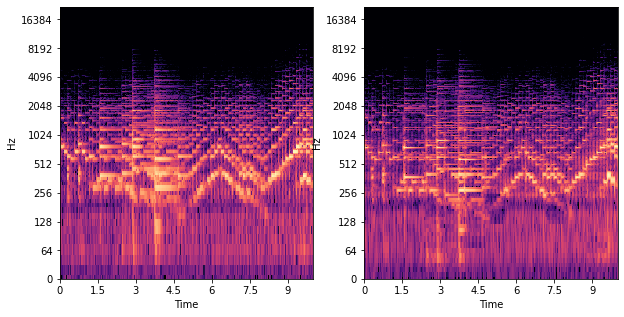

In [20]:
# Then, we can generate a visualization
vis = multires_spec.generate_visualization()

# ...and compare it to the original single resolution spectrogram
plt.figure(figsize=[10,5])

plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), y_axis='log', x_axis='time', sr=sr)

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(vis, ref=np.max), y_axis='log', x_axis='time', sr=sr)